In [1]:
#https://keras.io/examples/lstm_stateful/
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
%matplotlib inline
# ----------------------------------------------------------
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 2

# The input sequence length that the LSTM is trained on for each output point
lahead = 10

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 100

# ------------
# MAIN PROGRAM
# ------------

print("*" * 33)
if lahead >= tsteps:
    print("STATELESS LSTM WILL ALSO CONVERGE")
else:
    print("STATELESS LSTM WILL NOT CONVERGE")
print("*" * 33)

np.random.seed(1986)

print('Generating Data...')


def gen_uniform_amp(amp=1, xn=10000):
    """Generates uniform random data between
    -amp and +amp
    and of length xn

    # Arguments
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = np.random.uniform(-1 * amp, +1 * amp, xn)
    data_input = pd.DataFrame(data_input)
    return data_input

Using TensorFlow backend.
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

*********************************
STATELESS LSTM WILL ALSO CONVERGE
*********************************
Generating Data...


/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

Input shape: (1000, 10)
Output shape: (1000, 1)
Input head: 
           0         1         2         3         4         5         6  \
9   0.043727  0.038010  0.030332 -0.022773  0.040544  0.008981  0.079500   
10  0.038037  0.043727  0.038010  0.030332 -0.022773  0.040544  0.008981   
11  0.061361  0.038037  0.043727  0.038010  0.030332 -0.022773  0.040544   
12 -0.043250  0.061361  0.038037  0.043727  0.038010  0.030332 -0.022773   
13  0.051536 -0.043250  0.061361  0.038037  0.043727  0.038010  0.030332   

           7         8         9  
9   0.021696 -0.084532  0.013775  
10  0.079500  0.021696 -0.084532  
11  0.008981  0.079500  0.021696  
12  0.040544  0.008981  0.079500  
13 -0.022773  0.040544  0.008981  
Output head: 
           0
9   0.040869
10  0.040882
11  0.049699
12  0.009055
13  0.004143
Input tail: 
             0         1         2         3         4         5         6  \
1004 -0.024574  0.070105 -0.080260 -0.097307 -0.057877  0.028471  0.003984   
1005  0.050

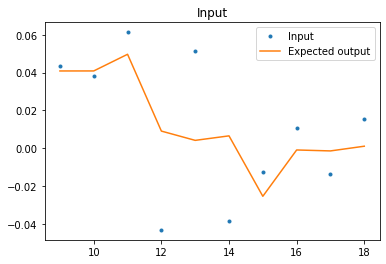

In [2]:
# Since the output is a moving average of the input,
# the first few points of output will be NaN
# and will be dropped from the generated data
# before training the LSTM.
# Also, when lahead > 1,
# the preprocessing step later of "rolling window view"
# will also cause some points to be lost.
# For aesthetic reasons,
# in order to maintain generated data length = input_len after pre-processing,
# add a few points to account for the values that will be lost.
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

# set the target to be a N-point average of the input
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

print('Input shape:', data_input.shape)
print('Output shape:', expected_output.shape)
print('Input head: ')
print(data_input.head())
print('Output head: ')
print(expected_output.head())
print('Input tail: ')
print(data_input.tail())
print('Output tail: ')
print(expected_output.tail())

print('Plotting input and expected output')
plt.plot(data_input[0][:10], '.')
plt.plot(expected_output[0][:10], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()

size of mooving window: 10
Plotting input and expected output


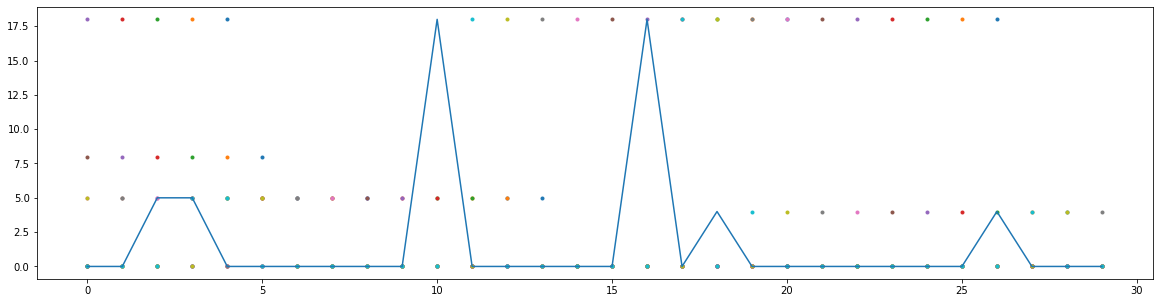

X:
[[ 0  0  0  0 18  8  5  0  5  0]
 [ 0  0  0 18  8  5  0  5  0  0]
 [ 0  0 18  8  5  0  5  0  0  0]
 [ 0 18  8  5  0  5  0  0  0  5]
 [18  8  5  0  5  0  0  0  5  5]
 [ 8  5  0  5  0  0  0  5  5  0]
 [ 5  0  5  0  0  0  5  5  0  0]
 [ 0  5  0  0  0  5  5  0  0  0]
 [ 5  0  0  0  5  5  0  0  0  0]
 [ 0  0  0  5  5  0  0  0  0  0]
 [ 0  0  5  5  0  0  0  0  0  0]
 [ 0  5  5  0  0  0  0  0  0 18]
 [ 5  5  0  0  0  0  0  0 18  0]
 [ 5  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0 18]
 [ 0  0 18  0  0  0  0  0 18  0]
 [ 0 18  0  0  0  0  0 18  0  4]]
y:
[[ 0]
 [ 0]
 [ 5]
 [ 5]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [18]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [18]
 [ 0]
 [ 4]
 [ 0]]


In [3]:
from pandas import read_csv
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def lioshas_data():
    series = read_csv('db_seq.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
    d=series.values
    return d

print('size of mooving window:', lahead)
X, y = split_sequence(lioshas_data(), lahead)

expected_output=pd.DataFrame(y)
data_input=pd.DataFrame(X)

print('Plotting input and expected output')
fig = plt.figure(figsize=(20,5))
plt.plot(data_input[:30], '.')
plt.plot(expected_output[:30], '-')
plt.show()

print('='*20)
print('X:')
print(data_input[:20].values)
print('='*20)
print('y:')
print(expected_output[:20].values)


Input shape: (1035, 10)
Output shape: (1035, 1)
Input head: 
    0    1    2    3    4     5     6     7     8     9
9   0  5.0  0.0  5.0  8.0  18.0   0.0   0.0   0.0   0.0
10  0  0.0  5.0  0.0  5.0   8.0  18.0   0.0   0.0   0.0
11  0  0.0  0.0  5.0  0.0   5.0   8.0  18.0   0.0   0.0
12  5  0.0  0.0  0.0  5.0   0.0   5.0   8.0  18.0   0.0
13  5  5.0  0.0  0.0  0.0   5.0   0.0   5.0   8.0  18.0
Output head: 
      0
9   2.5
10  0.0
11  0.0
12  2.5
13  5.0
Input tail: 
        0      1     2     3     4     5     6     7    8    9
1039    5    0.0  10.0  10.0   0.0   0.0   0.0   0.0  0.0  0.0
1040    0    5.0   0.0  10.0  10.0   0.0   0.0   0.0  0.0  0.0
1041    0    0.0   5.0   0.0  10.0  10.0   0.0   0.0  0.0  0.0
1042  200    0.0   0.0   5.0   0.0  10.0  10.0   0.0  0.0  0.0
1043    0  200.0   0.0   0.0   5.0   0.0  10.0  10.0  0.0  0.0
Output tail: 
          0
1039    2.5
1040    2.5
1041    0.0
1042  100.0
1043  100.0
Plotting input and expected output


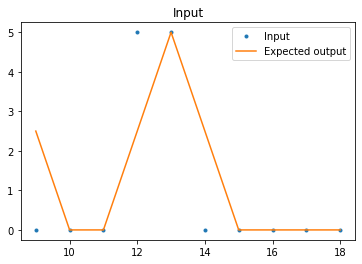

In [4]:
data_input=pd.DataFrame(lioshas_data())
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

print('Input shape:', data_input.shape)
print('Output shape:', expected_output.shape)
print('Input head: ')
print(data_input.head())
print('Output head: ')
print(expected_output.head())
print('Input tail: ')
print(data_input.tail())
print('Output tail: ')
print(expected_output.tail())

print('Plotting input and expected output')
plt.plot(data_input[0][:10], '.')
plt.plot(expected_output[0][:10], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()

In [5]:
def create_model(stateful):
    model = Sequential()
    model.add(LSTM(1,
              input_shape=(lahead, 1),
              batch_size=batch_size,
              stateful=stateful))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

print('Creating Stateful Model...')
model_stateful = create_model(stateful=True)


# split train/test data
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # tweak to match with batch_size
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # tweak to match with batch_size
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # some reshaping
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

print('Training')
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    model_stateful.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    model_stateful.reset_states()

print('Predicting')
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

print('Creating Stateless Model...')
model_stateless = create_model(stateful=False)

print('Training')
model_stateless.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

print('Predicting')
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

# ----------------------------

Creating Stateful Model...
x_train.shape:  (800, 10, 1)
y_train.shape:  (800, 1)
x_test.shape:  (235, 10, 1)
y_test.shape:  (235, 1)
Training
Epoch 1 / 100

Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 6s 7ms/step - loss: 210.7265 - val_loss: 245.7747
Epoch 2 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 203.8388 - val_loss: 239.3128
Epoch 3 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 199.3800 - val_loss: 234.9766
Epoch 4 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 196.5024 - val_loss: 232.1501
Epoch 5 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 194.6178 - val_loss: 230.0026
Epoch 6 / 100
Train on 800 samples, valida

800/800 [==============================] - 5s 7ms/step - loss: 187.1608 - val_loss: 220.2322
Epoch 49 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 187.1264 - val_loss: 220.1761
Epoch 50 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 187.0805 - val_loss: 220.1039
Epoch 51 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 187.0239 - val_loss: 220.0236
Epoch 52 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 186.9655 - val_loss: 219.9421
Epoch 53 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 186.9109 - val_loss: 219.8644
Epoch 54 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [=======

800/800 [==============================] - 5s 7ms/step - loss: 186.5841 - val_loss: 219.2130
Epoch 99 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 186.5845 - val_loss: 219.2134
Epoch 100 / 100
Train on 800 samples, validate on 235 samples
Epoch 1/1
800/800 [==============================] - 5s 7ms/step - loss: 186.5849 - val_loss: 219.2140
Predicting
Creating Stateless Model...
Training
Train on 800 samples, validate on 235 samples
Epoch 1/100
800/800 [==============================] - 6s 7ms/step - loss: 216.7299 - val_loss: 254.1660
Epoch 2/100
800/800 [==============================] - 5s 7ms/step - loss: 212.0422 - val_loss: 248.5105
Epoch 3/100
800/800 [==============================] - 5s 7ms/step - loss: 207.4589 - val_loss: 242.9472
Epoch 4/100
800/800 [==============================] - 5s 7ms/step - loss: 203.4506 - val_loss: 238.6678
Epoch 5/100
800/800 [==============================] - 5s 7ms/st

800/800 [==============================] - 5s 7ms/step - loss: 187.2357 - val_loss: 222.1057
Epoch 74/100
800/800 [==============================] - 5s 7ms/step - loss: 187.2240 - val_loss: 222.1328
Epoch 75/100
800/800 [==============================] - 5s 7ms/step - loss: 187.2126 - val_loss: 222.1592
Epoch 76/100
800/800 [==============================] - 5s 7ms/step - loss: 187.2015 - val_loss: 222.1848
Epoch 77/100
800/800 [==============================] - 5s 7ms/step - loss: 187.1908 - val_loss: 222.2097
Epoch 78/100
800/800 [==============================] - 5s 7ms/step - loss: 187.1803 - val_loss: 222.2337
Epoch 79/100
800/800 [==============================] - 5s 7ms/step - loss: 187.1701 - val_loss: 222.2570
Epoch 80/100
800/800 [==============================] - 5s 7ms/step - loss: 187.1602 - val_loss: 222.2795
Epoch 81/100
800/800 [==============================] - 5s 7ms/step - loss: 187.1506 - val_loss: 222.3012
Epoch 82/100
800/800 [==============================] - 5s 

Plotting Results


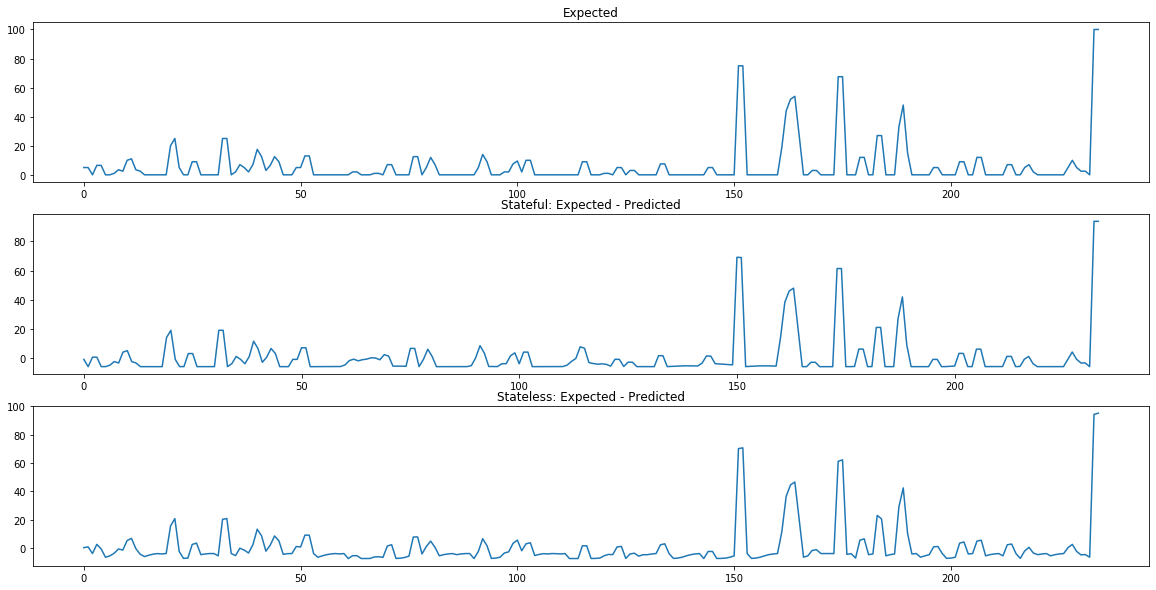

In [8]:
fig = plt.figure(figsize=(20, 10))
print('Plotting Results')
plt.subplot(3, 1, 1)
plt.plot(y_test)

plt.title('Expected')
plt.subplot(3, 1, 2)
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title('Stateful: Expected - Predicted')
plt.subplot(3, 1, 3)
#plt.ylim(top=1)
#plt.ylim(bottom=-1)
plt.plot((y_test - predicted_stateless).flatten())
plt.title('Stateless: Expected - Predicted')
plt.show()

Plotting Results


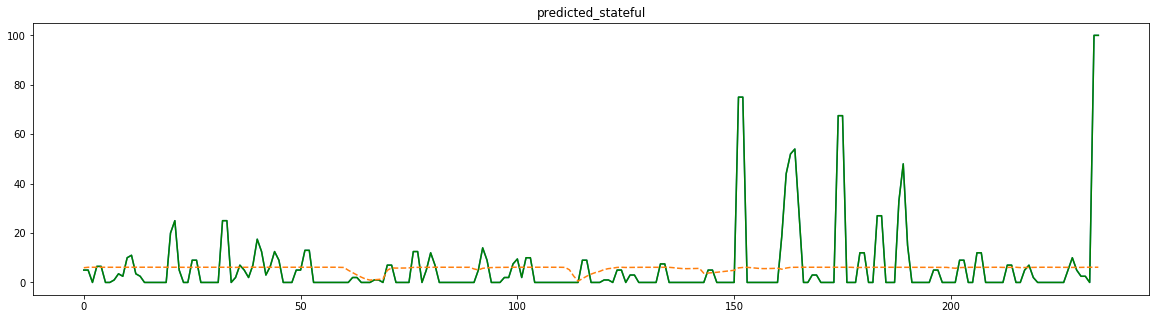

In [9]:
fig = plt.figure(figsize=(20, 5))
print('Plotting Results')
plt.plot(y_test)
plt.title('predicted_stateful')
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot(y_test, c='green')
plt.plot(predicted_stateful, c='#FF7F0E', linestyle='--')

Plotting Results


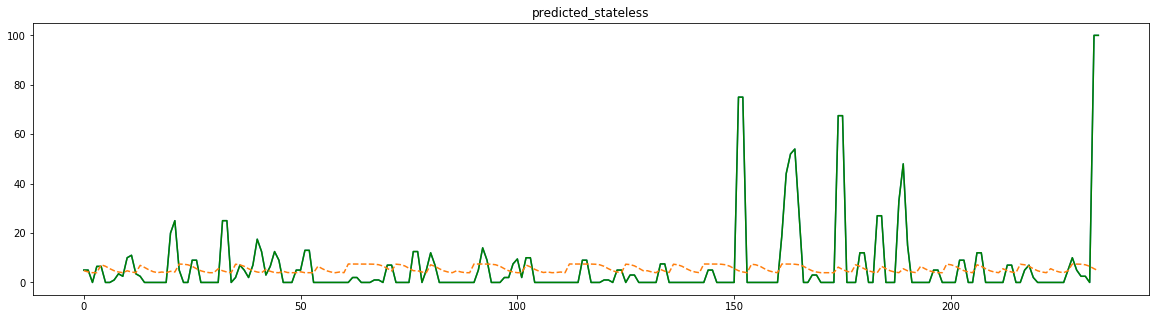

In [10]:
fig = plt.figure(figsize=(20, 5))
print('Plotting Results')
plt.plot(y_test)
plt.title('predicted_stateless')
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot(y_test, c='green')
plt.plot(predicted_stateless, c='#FF7F0E', linestyle='--')

In [12]:
#predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)
gen_inp=[]
for i in range(0, 1000):
    if i<len(x_test): 
        #print(i, x_test[i][0], x_test[i][1], x_test[i][2])
        gen_inp=x_test[i]
    else:
        tmp=gen_inp
        print('#before pred:', tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5],
             tmp[6], tmp[7], tmp[8], tmp[9])
        t = tmp.reshape((1, 10, 1))
        new_inp = model_stateful.predict(t, batch_size=batch_size)
        #new_inp = model_stateless.predict(t, batch_size=batch_size)
        
        gen_inp=np.array([new_inp, tmp[0], tmp[1], tmp[2], tmp[3], 
                          tmp[4], tmp[5], tmp[6], tmp[7], tmp[8] ])
        print('#after  pred:', gen_inp[0], gen_inp[1], gen_inp[2], gen_inp[3],
             gen_inp[4], gen_inp[5], gen_inp[6], gen_inp[7], gen_inp[8], gen_inp[9])
        print('='*20)
        
    

#before pred: [0.] [200.] [0.] [0.] [5.] [0.] [10.] [10.] [0.] [0.]
#after  pred: [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0] [10.0] [0.0]
#before pred: [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0] [10.0] [0.0]
#after  pred: [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0] [10.0]
#before pred: [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0] [10.0]
#after  pred: [6.160518646240234] [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0]
#before pred: [6.160518646240234] [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0] [10.0]
#after  pred: [6.160447120666504] [6.160518646240234] [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0]
#before pred: [6.160447120666504] [6.160518646240234] [6.154616355895996] [6.1545000076293945] [0.0] [200.0] [0.0] [0.0] [5.0] [0.0]
#after  pred: [6.154575347

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.158

#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#before pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
#after  pred: [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695] [6.1583757400512695]
